In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from ariel.body_phenotypes.robogen_lite.config import (
    NUM_OF_FACES,
    NUM_OF_ROTATIONS,
    NUM_OF_TYPES_OF_MODULES,
)
from ariel.body_phenotypes.robogen_lite.decoders.hi_prob_decoding import (
    HighProbabilityDecoder,
)
from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.gui_vis.view_mujoco import (
    get_cloud_of_robot_from_graph,
    simple_cloud_distance,
)

In [36]:
N_ROBOTS = 1000
NUM_MODULES = 20
SEED = 42
RNG = np.random.default_rng(SEED)

robots = []
point_clouds = []

In [37]:
for _ in tqdm(range(N_ROBOTS), desc="Generating robots"):
    type_prob = RNG.random(size=(NUM_MODULES, NUM_OF_TYPES_OF_MODULES), dtype=np.float32)
    conn_prob = RNG.random(size=(NUM_MODULES, NUM_MODULES, NUM_OF_FACES), dtype=np.float32)
    rot_prob = RNG.random(size=(NUM_MODULES, NUM_OF_ROTATIONS), dtype=np.float32)

    hpd = HighProbabilityDecoder(NUM_MODULES)
    robot_graph = hpd.probability_matrices_to_graph(type_prob, conn_prob, rot_prob)
    robots.append(robot_graph)

    pc = get_cloud_of_robot_from_graph(robot_graph)
    point_clouds.append(pc)

print(f"Generated {len(robots)} robots and relative point clouds.")

Generating robots: 100%|██████████| 1000/1000 [00:07<00:00, 135.80it/s]

Generated 1000 robots and relative point clouds.


In [38]:
ref_index = 0
ref_cloud = point_clouds[ref_index]

distances = []

for i, pc in enumerate(point_clouds):
    if i == ref_index:
        distances.append(0.0)
    else:
        d = simple_cloud_distance(ref_cloud, pc)
        distances.append(d)

In [39]:
radius_strategy = ctk.RadiusStrategy.NODE_LOCAL
max_tree_radius = None
missing_data_mode = ctk.MissingDataMode.SKIP_RADIUS
tanimoto_mode = ctk.TanimotoMode.COUNTS
weighting_mode = ctk.WeightingMode.LINEAR

softmax_beta = 1
power_mean_p = 1

similarity_config = ctk.create_similarity_config(
    radius_strategy=radius_strategy,
    weighting_mode=weighting_mode,
    max_tree_radius=max_tree_radius,
    missing_data_mode=missing_data_mode,
    tanimoto_mode=tanimoto_mode,
    softmax_beta=softmax_beta,
    power_mean_p=power_mean_p
)
ctk_similarities = []
ref_robot_graph = robots[ref_index]

for robot in tqdm(robots, desc="Computing CTK similarity"):
    sim = ctk.calculate_similarity(ref_robot_graph, robot, similarity_config)
    ctk_similarities.append(sim)

Computing CTK similarity: 100%|██████████| 1000/1000 [00:23<00:00, 43.05it/s]


In [24]:
df_sim = pd.DataFrame({
    "robot_id": list(range(N_ROBOTS)),
    "point_cloud_distance": distances,
    "ctk_similarity": ctk_similarities,
})

print(df_sim.head())

   robot_id  point_cloud_distance  ctk_similarity
0         0              0.000000           1.000
1         1           1970.534925           0.016
2         2           2053.940370           0.017
3         3           1299.764957           0.018
4         4           1544.368131           0.026


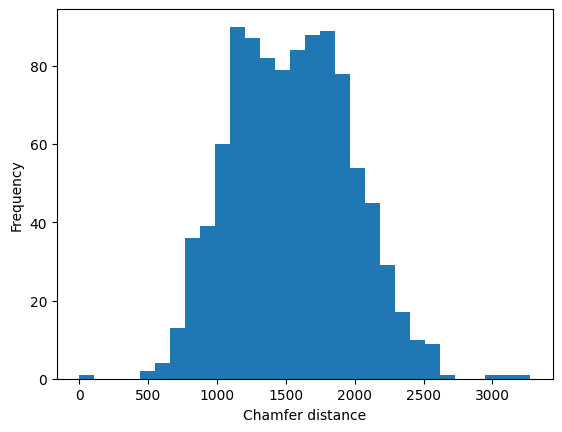

In [40]:
plt.hist(df_sim["point_cloud_distance"], bins=30)
plt.xlabel("Chamfer distance")
plt.ylabel("Frequency")
plt.show()

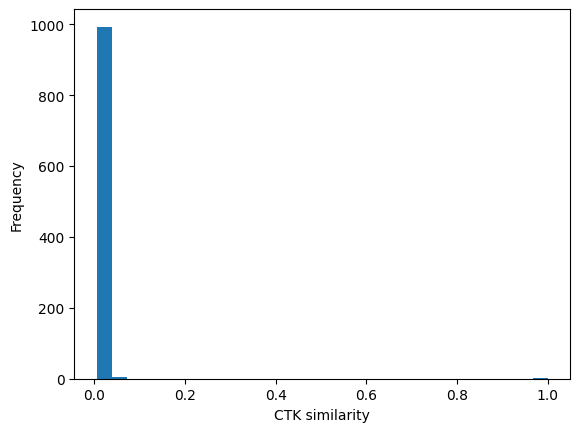

In [41]:
plt.hist(df_sim["ctk_similarity"], bins=30)
plt.xlabel("CTK similarity")
plt.ylabel("Frequency")
plt.show()